In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

In [10]:
def read_omp_file(filename):
    re_width = re.compile("### width( *):( *)([^ ]*)")
    re_height = re.compile("### height( *):( *)([^ ]*)")
    re_halo = re.compile("### halo( *):( *)([^ ]*)")
    re_threads = re.compile("### threads( *):( *)([^ ]*)")
    re_comp_t = re.compile("comp_time:( *)([^ ]*)( *)\+-")
    re_total_t = re.compile("totl_time:( *)([^ ]*)( *)ms")
    table = pd.DataFrame(columns=['width', 'height', 'halo', 'threads', 'comp_t', 'total_t'])
    with open(filename, 'r') as infile:
        #skip the first line
        infile.readline()
        line = infile.readline()
        while (line):
            width = int(re_width.search(line).group(3))
            height = int(re_height.search(infile.readline()).group(3))
            halo = int(re_halo.search(infile.readline()).group(3))
            threads = int(re_threads.search(infile.readline()).group(3))
            infile.readline()
            infile.readline()
            comp_t = float(re_comp_t.search(infile.readline()).group(2)) / 1e3
            infile.readline()
            total_t = float(re_total_t.search(infile.readline()).group(2)) / 1e3
            line = infile.readline()
            table = table.append({'width': width, 'height': height, 'halo': halo, 'threads': threads, 'comp_t': comp_t, 'total_t': total_t}, ignore_index=True)
            
    return table

In [15]:
def omp_plots(filename, strong=True):
    df = read_omp_file(filename)
    df = df.iloc[:,-3:].groupby('threads').agg(['mean', 'std'])
    
    fig_t, ax_t = plt.subplots()
    ax_t.errorbar(df.index, df[('comp_t', 'mean')], yerr=df[('comp_t','std')])
    ax_t.errorbar(df.index, df[('total_t', 'mean')], yerr=df[('total_t', 'std')])
    ax_t.legend(["comp time", "total time"])
    ax_t.set_ylabel("t [s]")
    plt.show()
    
    df[('comp_s', 'mean')] = df.iloc[0,0] / df[('comp_t', 'mean')]
    df[('comp_s', 'std')] = (df.iloc[0,1] / df.iloc[0,0] + df[('comp_t', 'std')] / df[('comp_t', 'mean')]) * df[('comp_s', 'mean')]
    df[('total_s', 'mean')] = df.iloc[0,2] / df[('total_t', 'mean')]
    df[('total_s', 'std')] = (df.iloc[0,3] / df.iloc[0,2] + df[('total_t', 'std')] / df[('total_t', 'mean')]) * df[('total_s', 'mean')]
    
    fig_s, ax_s = plt.subplots()
    ax_s.errorbar(df.index, df[('comp_s', 'mean')], yerr=df[('comp_s', 'std')])
    ax_s.errorbar(df.index, df[('total_s', 'mean')], yerr=df[('total_s', 'std')])
    if strong == True:
        ax_s.plot(df.index, df.index)
    else:
        ax_s.plot(df.index, df.index.size * [1.0])
    ax_s.legend(["comp speedup", "total speedup", "theoretical speedup"])
    plt.show()

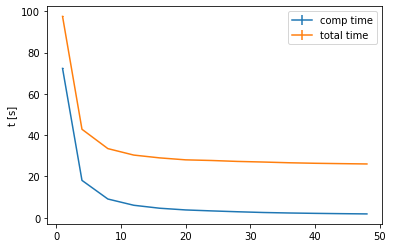

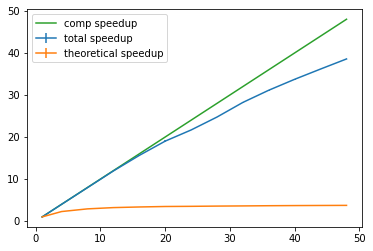

In [12]:
omp_plots("omp_strong_011.txt")

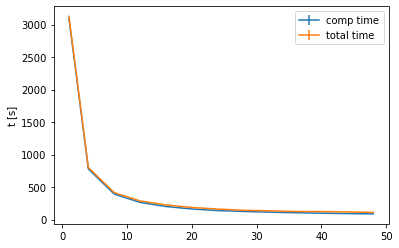

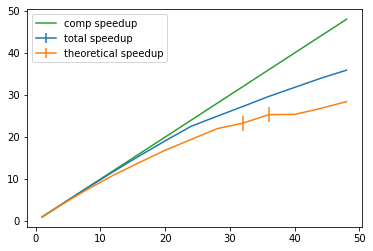

In [13]:
omp_plots("omp_strong_101.txt")

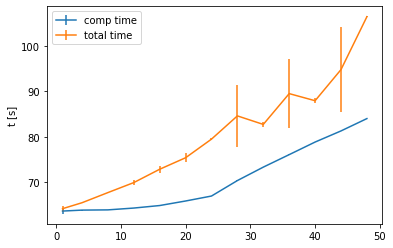

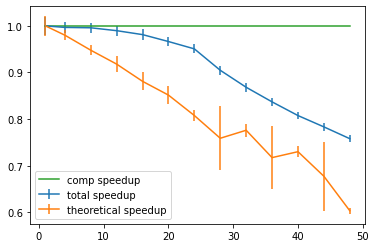

In [17]:
omp_plots("omp_weak_101.txt", False)

In [49]:
def read_mpi_file(filename):
    reg_expr = re.compile("Elapsed time with( *)([^ ]*) nodes:( *)([^ ]*) s")
    with open(filename, 'r') as infile:
        infile.readline()
        line = infile.readline()
        table = pd.DataFrame(columns=['procs', 'time'])
        while (line):
            procs = int(reg_expr.search(line).group(2))
            time = float(reg_expr.search(line).group(4))
            line = infile.readline()
            table = table.append({'procs': procs, 'time': time}, ignore_index=True)
            
    return table

In [53]:
def mpi_plots(filename, strong=True):
    df = read_mpi_file(filename)
    df = df.groupby('procs').agg(['mean', 'std'])
    
    fig_t, ax_t = plt.subplots()
    ax_t.errorbar(df.index, df[('time','mean')], yerr=df[('time','std')])
    plt.show()
    
    df[('speedup','mean')] = df.iloc[0,0] / df[('time','mean')]
    df[('speedup','std')] = (df.iloc[0,1] / df.iloc[0,0] + df[('time','std')] / df[('time','mean')]) * df[('speedup','mean')]
    fig_s, ax_s = plt.subplots()
    ax_s.errorbar(df.index, df[('speedup','mean')], yerr=df[('speedup','std')])
    if strong == True:
        ax_s.plot(df.index, df.index)
    else:
        ax_s.plot(df.index, df.index.size * [1.0])
    plt.show()

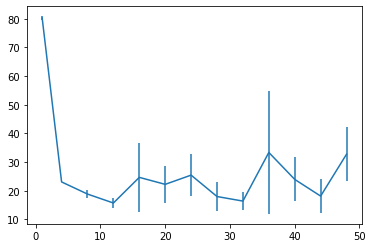

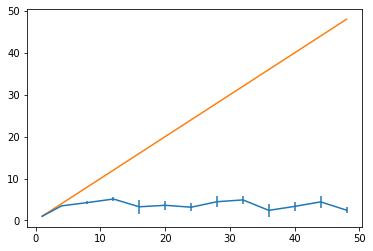

In [54]:
mpi_plots("mpi_strong_011.txt")

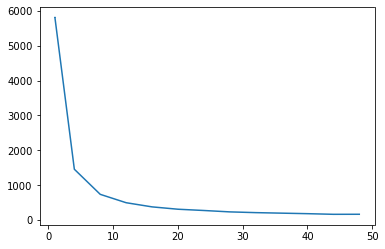

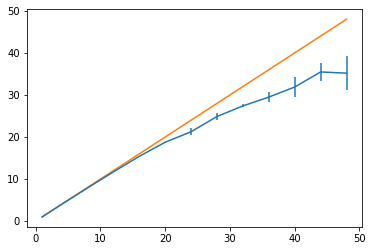

In [55]:
mpi_plots("mpi_strong_101.txt")

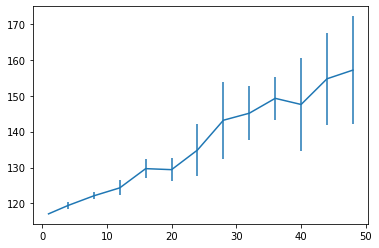

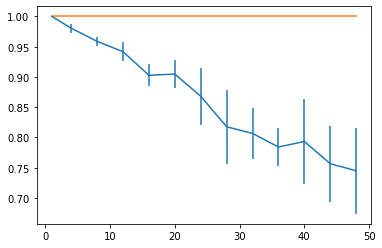

In [56]:
mpi_plots("mpi_weak_101.txt", False)